# Diplodatos Kaggle Competition

We present this peace of code to create the baseline for the competition, and as an example of how to deal with these kind of problems. The main goals are that you:

1. Learn
1. Try different models and see which one fits the best the given data
1. Get a higher score than the given one in the current baseline example
1. Try to get the highest score in the class :)

In [49]:
# Import the required packages
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Read the *original* dataset...

In [50]:
original_df = pd.read_csv('https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/practico/data/train.csv')

In [51]:
original_df.columns

Index(['TripType', 'VisitNumber', 'Weekday', 'Upc', 'ScanCount',
       'DepartmentDescription', 'FinelineNumber'],
      dtype='object')

**TripType** is the column that we should predict. That column is not present in the test set

In [52]:
original_df.describe()

,TripType,VisitNumber,Upc,ScanCount,FinelineNumber
count,453411.000000,453411.000000,4.505590e+05,453411.000000,450559.000000
mean,58.027039,95909.846115,3.075243e+10,1.108584,3727.366554
std,155.973370,55399.801147,9.163940e+10,0.707029,2779.958546
min,3.000000,5.000000,8.340000e+02,-10.000000,0.000000
25%,27.000000,49390.000000,3.400004e+09,1.000000,1404.000000
50%,39.000000,96781.000000,7.056082e+09,1.000000,3352.000000
75%,40.000000,143930.000000,3.013201e+10,1.000000,5501.000000
max,999.000000,191347.000000,9.789707e+11,71.000000,9998.000000


In [53]:
original_df.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,8,9,Friday,1.070081e+09,1,IMPULSE MERCHANDISE,115.0
2,8,9,Friday,3.107000e+03,1,PRODUCE,103.0
3,8,9,Friday,4.011000e+03,1,PRODUCE,5501.0
4,8,10,Friday,6.414410e+09,1,DSD GROCERY,2008.0


Looking into the columns values...

In [54]:
set(original_df.Weekday)

{'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'}

In [55]:
set(original_df.DepartmentDescription)

{'1-HR PHOTO',
 'ACCESSORIES',
 'AUTOMOTIVE',
 'BAKERY',
 'BATH AND SHOWER',
 'BEAUTY',
 'BEDDING',
 'BOOKS AND MAGAZINES',
 'BOYS WEAR',
 'BRAS & SHAPEWEAR',
 'CAMERAS AND SUPPLIES',
 'CANDY, TOBACCO, COOKIES',
 'CELEBRATION',
 'COMM BREAD',
 'CONCEPT STORES',
 'COOK AND DINE',
 'DAIRY',
 'DSD GROCERY',
 'ELECTRONICS',
 'FABRICS AND CRAFTS',
 'FINANCIAL SERVICES',
 'FROZEN FOODS',
 'FURNITURE',
 'GIRLS WEAR, 4-6X  AND 7-14',
 'GROCERY DRY GOODS',
 'HARDWARE',
 'HEALTH AND BEAUTY AIDS',
 'HOME DECOR',
 'HOME MANAGEMENT',
 'HORTICULTURE AND ACCESS',
 'HOUSEHOLD CHEMICALS/SUPP',
 'HOUSEHOLD PAPER GOODS',
 'IMPULSE MERCHANDISE',
 'INFANT APPAREL',
 'INFANT CONSUMABLE HARDLINES',
 'JEWELRY AND SUNGLASSES',
 'LADIES SOCKS',
 'LADIESWEAR',
 'LARGE HOUSEHOLD GOODS',
 'LAWN AND GARDEN',
 'LIQUOR,WINE,BEER',
 'MEAT - FRESH & FROZEN',
 'MEDIA AND GAMING',
 'MENS WEAR',
 'MENSWEAR',
 'OFFICE SUPPLIES',
 'OPTICAL - FRAMES',
 'OPTICAL - LENSES',
 'OTHER DEPARTMENTS',
 'PAINT AND ACCESSORIES',
 'PER

There are `nan`s in the column, let us find them...

In [56]:
original_df[original_df.DepartmentDescription.isna()]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
739,999,484,Friday,NaN,-2,NaN,NaN
740,999,484,Friday,NaN,-2,NaN,NaN
1292,32,845,Friday,NaN,1,NaN,NaN
1293,32,845,Friday,NaN,1,NaN,NaN
1577,40,1004,Friday,NaN,1,NaN,NaN
...,...,...,...,...,...,...,...
449840,40,190133,Sunday,NaN,1,NaN,NaN
450036,999,190182,Sunday,NaN,-1,NaN,NaN
450163,40,190230,Sunday,NaN,1,NaN,NaN
450361,39,190309,Sunday,NaN,1,NaN,NaN


When the description is NaN, then the Upc and FinelineNumber are both NaN?

In [57]:
(original_df.DepartmentDescription.isna().sum(),
 (original_df.DepartmentDescription.isna() & original_df.Upc.isna() & original_df.FinelineNumber.isna()).sum())

(972, 972)

In [58]:
original_df[original_df.Upc.isna()]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
739,999,484,Friday,NaN,-2,NaN,NaN
740,999,484,Friday,NaN,-2,NaN,NaN
900,5,585,Friday,NaN,1,PHARMACY RX,NaN
944,5,619,Friday,NaN,1,PHARMACY RX,NaN
945,5,619,Friday,NaN,1,PHARMACY RX,NaN
...,...,...,...,...,...,...,...
449840,40,190133,Sunday,NaN,1,NaN,NaN
450036,999,190182,Sunday,NaN,-1,NaN,NaN
450163,40,190230,Sunday,NaN,1,NaN,NaN
450361,39,190309,Sunday,NaN,1,NaN,NaN


But it may be the case that Upc is NaN but not the description...

In [59]:
(original_df.Upc.isna().sum(),
 original_df.FinelineNumber.isna().sum(),
 (original_df.FinelineNumber.isna() & original_df.Upc.isna()).sum())

(2852, 2852, 2852)

Upc and FinelineNumber are both NaN at the same time

Our last step in this analysis is to see how balanced is the data...

In [60]:
bins = set(original_df.TripType)

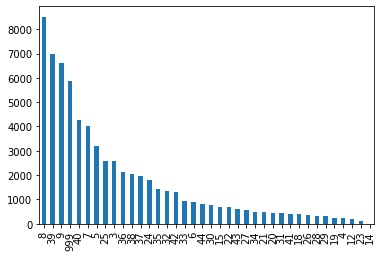

In [61]:
# to count the TripType values, we have to group the visits by VisitNumber
original_df.groupby("VisitNumber").TripType.mean().value_counts().plot(kind='bar')

**Unbalanced!!!**

Create a function to load the datasets.

**Some important decisions made here**:
1. We will use one hot encoding for Weekday and DepartmentDescription. All transformations are applied to the training and testing datasets...
1. We are handling NaN's as another category. This may not be the best approach.
1. We may have multiple records for one single visit and the goal is to classify all those records the exact same way. Therefore, we will prepare the data in a way that all the information for a visit is in the same record.
1. Based on the last bullet, we will count the DepartmentDescription for all items acquired in the same visit.
1. We drop the Upc and FinelineNumber to simplify the process. You may use it as they have a lot of information (may be using one-hot encoding for them as well)

The following operations will be performed in a function. Anyway, we present them here so that we can see them in action:

First, we drop the columns. We include TripType as we are going to treat it differently:

In [62]:
df = original_df.drop(["Upc", "FinelineNumber", "TripType"], axis=1)

In [63]:
df

,VisitNumber,Weekday,ScanCount,DepartmentDescription
0,5,Friday,-1,FINANCIAL SERVICES
1,9,Friday,1,IMPULSE MERCHANDISE
2,9,Friday,1,PRODUCE
3,9,Friday,1,PRODUCE
4,10,Friday,1,DSD GROCERY
...,...,...,...,...
453406,191344,Sunday,1,BEAUTY
453407,191344,Sunday,1,WIRELESS
453408,191344,Sunday,1,BEAUTY
453409,191347,Sunday,1,DAIRY


Now, we create the dummy columns

In [64]:
df = pd.get_dummies(df, columns=["DepartmentDescription"], dummy_na=True)

In [65]:
df

,VisitNumber,Weekday,ScanCount,DepartmentDescription_1-HR PHOTO,DepartmentDescription_ACCESSORIES,DepartmentDescription_AUTOMOTIVE,DepartmentDescription_BAKERY,DepartmentDescription_BATH AND SHOWER,DepartmentDescription_BEAUTY,DepartmentDescription_BEDDING,DepartmentDescription_BOOKS AND MAGAZINES,DepartmentDescription_BOYS WEAR,DepartmentDescription_BRAS & SHAPEWEAR,DepartmentDescription_CAMERAS AND SUPPLIES,"DepartmentDescription_CANDY, TOBACCO, COOKIES",DepartmentDescription_CELEBRATION,DepartmentDescription_COMM BREAD,DepartmentDescription_CONCEPT STORES,DepartmentDescription_COOK AND DINE,DepartmentDescription_DAIRY,DepartmentDescription_DSD GROCERY,DepartmentDescription_ELECTRONICS,DepartmentDescription_FABRICS AND CRAFTS,DepartmentDescription_FINANCIAL SERVICES,DepartmentDescription_FROZEN FOODS,DepartmentDescription_FURNITURE,"DepartmentDescription_GIRLS WEAR, 4-6X AND 7-14",DepartmentDescription_GROCERY DRY GOODS,DepartmentDescription_HARDWARE,DepartmentDescription_HEALTH AND BEAUTY AIDS,DepartmentDescription_HOME DECOR,DepartmentDescription_HOME MANAGEMENT,DepartmentDescription_HORTICULTURE AND ACCESS,DepartmentDescription_HOUSEHOLD CHEMICALS/SUPP,DepartmentDescription_HOUSEHOLD PAPER GOODS,DepartmentDescription_IMPULSE MERCHANDISE,DepartmentDescription_INFANT APPAREL,DepartmentDescription_INFANT CONSUMABLE HARDLINES,DepartmentDescription_JEWELRY AND SUNGLASSES,DepartmentDescription_LADIES SOCKS,DepartmentDescription_LADIESWEAR,DepartmentDescription_LARGE HOUSEHOLD GOODS,DepartmentDescription_LAWN AND GARDEN,"DepartmentDescription_LIQUOR,WINE,BEER",DepartmentDescription_MEAT - FRESH & FROZEN,DepartmentDescription_MEDIA AND GAMING,DepartmentDescription_MENS WEAR,DepartmentDescription_MENSWEAR,DepartmentDescription_OFFICE SUPPLIES,DepartmentDescription_OPTICAL - FRAMES,DepartmentDescription_OPTICAL - LENSES,DepartmentDescription_OTHER DEPARTMENTS,DepartmentDescription_PAINT AND ACCESSORIES,DepartmentDescription_PERSONAL CARE,DepartmentDescription_PETS AND SUPPLIES,DepartmentDescription_PHARMACY OTC,DepartmentDescription_PHARMACY RX,DepartmentDescription_PLAYERS AND ELECTRONICS,DepartmentDescription_PLUS AND MATERNITY,DepartmentDescription_PRE PACKED DELI,DepartmentDescription_PRODUCE,DepartmentDescription_SEAFOOD,DepartmentDescription_SEASONAL,DepartmentDescription_SERVICE DELI,DepartmentDescription_SHEER HOSIERY,DepartmentDescription_SHOES,DepartmentDescription_SLEEPWEAR/FOUNDATIONS,DepartmentDescription_SPORTING GOODS,DepartmentDescription_SWIMWEAR/OUTERWEAR,DepartmentDescription_TOYS,DepartmentDescription_WIRELESS,DepartmentDescription_nan
0,5,Friday,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,Friday,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9,Friday,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,9,Friday,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,10,Friday,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453406,191344,Sunday,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
453407,191344,Sunday,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
453408,191344,Sunday,1,0,0,0,0,0

Now, we group by the VisitNumber and Weekday (they should be the same), and add all values for ScanCount, and the one-hot encoding of DepartmentDescriptioin

In [66]:
df = df.groupby(["VisitNumber", "Weekday"], as_index=False).sum()

In [67]:
df

,VisitNumber,Weekday,ScanCount,DepartmentDescription_1-HR PHOTO,DepartmentDescription_ACCESSORIES,DepartmentDescription_AUTOMOTIVE,DepartmentDescription_BAKERY,DepartmentDescription_BATH AND SHOWER,DepartmentDescription_BEAUTY,DepartmentDescription_BEDDING,DepartmentDescription_BOOKS AND MAGAZINES,DepartmentDescription_BOYS WEAR,DepartmentDescription_BRAS & SHAPEWEAR,DepartmentDescription_CAMERAS AND SUPPLIES,"DepartmentDescription_CANDY, TOBACCO, COOKIES",DepartmentDescription_CELEBRATION,DepartmentDescription_COMM BREAD,DepartmentDescription_CONCEPT STORES,DepartmentDescription_COOK AND DINE,DepartmentDescription_DAIRY,DepartmentDescription_DSD GROCERY,DepartmentDescription_ELECTRONICS,DepartmentDescription_FABRICS AND CRAFTS,DepartmentDescription_FINANCIAL SERVICES,DepartmentDescription_FROZEN FOODS,DepartmentDescription_FURNITURE,"DepartmentDescription_GIRLS WEAR, 4-6X AND 7-14",DepartmentDescription_GROCERY DRY GOODS,DepartmentDescription_HARDWARE,DepartmentDescription_HEALTH AND BEAUTY AIDS,DepartmentDescription_HOME DECOR,DepartmentDescription_HOME MANAGEMENT,DepartmentDescription_HORTICULTURE AND ACCESS,DepartmentDescription_HOUSEHOLD CHEMICALS/SUPP,DepartmentDescription_HOUSEHOLD PAPER GOODS,DepartmentDescription_IMPULSE MERCHANDISE,DepartmentDescription_INFANT APPAREL,DepartmentDescription_INFANT CONSUMABLE HARDLINES,DepartmentDescription_JEWELRY AND SUNGLASSES,DepartmentDescription_LADIES SOCKS,DepartmentDescription_LADIESWEAR,DepartmentDescription_LARGE HOUSEHOLD GOODS,DepartmentDescription_LAWN AND GARDEN,"DepartmentDescription_LIQUOR,WINE,BEER",DepartmentDescription_MEAT - FRESH & FROZEN,DepartmentDescription_MEDIA AND GAMING,DepartmentDescription_MENS WEAR,DepartmentDescription_MENSWEAR,DepartmentDescription_OFFICE SUPPLIES,DepartmentDescription_OPTICAL - FRAMES,DepartmentDescription_OPTICAL - LENSES,DepartmentDescription_OTHER DEPARTMENTS,DepartmentDescription_PAINT AND ACCESSORIES,DepartmentDescription_PERSONAL CARE,DepartmentDescription_PETS AND SUPPLIES,DepartmentDescription_PHARMACY OTC,DepartmentDescription_PHARMACY RX,DepartmentDescription_PLAYERS AND ELECTRONICS,DepartmentDescription_PLUS AND MATERNITY,DepartmentDescription_PRE PACKED DELI,DepartmentDescription_PRODUCE,DepartmentDescription_SEAFOOD,DepartmentDescription_SEASONAL,DepartmentDescription_SERVICE DELI,DepartmentDescription_SHEER HOSIERY,DepartmentDescription_SHOES,DepartmentDescription_SLEEPWEAR/FOUNDATIONS,DepartmentDescription_SPORTING GOODS,DepartmentDescription_SWIMWEAR/OUTERWEAR,DepartmentDescription_TOYS,DepartmentDescription_WIRELESS,DepartmentDescription_nan
0,5,Friday,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,Friday,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
2,10,Friday,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,11,Friday,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,12,Friday,7,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67024,191329,Sunday,20,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,7,2,0,0,0,1,1,0,0,0,0,0,1,4,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
67025,191337,Sunday,27,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,5,3,0,0,0,2,0,0,10,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
67026,191343,Sunday,9,0,0,0,0

In [68]:
def transform_data(train_data_fname, test_data_fname):
    df_train = pd.read_csv(train_data_fname)
    df_train['is_train_set'] = 1
    df_test = pd.read_csv(test_data_fname)
    df_test['is_train_set'] = 0

    # we  get the TripType for the train set. To do that, we group by VisitNumber and
    # then we get the max (or min or avg)
    y = df_train.groupby(["VisitNumber", "Weekday"], as_index=False).max().TripType

    # we remove the TripType now, and concat training and testing data
    # the concat is done so that we have the same columns for both datasets
    # after one-hot encoding
    df_train = df_train.drop("TripType", axis=1)
    df = pd.concat([df_train, df_test])
    
    # the next three operations are the ones we have just presented in the previous lines
    
    # drop the columns we won't use (it may be good to use them somehow)
    df = df.drop(["Upc", "FinelineNumber"], axis=1)

    # one-hot encoding for the DepartmentDescription
    df = pd.get_dummies(df, columns=["DepartmentDescription"], dummy_na=True)

    # now we add the groupby values
    df = df.groupby(["VisitNumber", "Weekday"], as_index=False).sum()
    
    # finally, we do one-hot encoding for the Weekday
    df = pd.get_dummies(df, columns=["Weekday"], dummy_na=True)

    # get train and test back
    df_train = df[df.is_train_set != 0]
    df_test = df[df.is_train_set == 0]
    
    X = df_train.drop(["is_train_set"], axis=1)
    yy = None
    XX = df_test.drop(["is_train_set"], axis=1)

    return X, y, XX, yy

Load the data...

In [69]:
X, y, XX, yy = transform_data('https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/practico/data/train.csv',
                              "https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/practico/data/test.csv")

In [70]:
X

,VisitNumber,ScanCount,DepartmentDescription_1-HR PHOTO,DepartmentDescription_ACCESSORIES,DepartmentDescription_AUTOMOTIVE,DepartmentDescription_BAKERY,DepartmentDescription_BATH AND SHOWER,DepartmentDescription_BEAUTY,DepartmentDescription_BEDDING,DepartmentDescription_BOOKS AND MAGAZINES,DepartmentDescription_BOYS WEAR,DepartmentDescription_BRAS & SHAPEWEAR,DepartmentDescription_CAMERAS AND SUPPLIES,"DepartmentDescription_CANDY, TOBACCO, COOKIES",DepartmentDescription_CELEBRATION,DepartmentDescription_COMM BREAD,DepartmentDescription_CONCEPT STORES,DepartmentDescription_COOK AND DINE,DepartmentDescription_DAIRY,DepartmentDescription_DSD GROCERY,DepartmentDescription_ELECTRONICS,DepartmentDescription_FABRICS AND CRAFTS,DepartmentDescription_FINANCIAL SERVICES,DepartmentDescription_FROZEN FOODS,DepartmentDescription_FURNITURE,"DepartmentDescription_GIRLS WEAR, 4-6X AND 7-14",DepartmentDescription_GROCERY DRY GOODS,DepartmentDescription_HARDWARE,DepartmentDescription_HEALTH AND BEAUTY AIDS,DepartmentDescription_HOME DECOR,DepartmentDescription_HOME MANAGEMENT,DepartmentDescription_HORTICULTURE AND ACCESS,DepartmentDescription_HOUSEHOLD CHEMICALS/SUPP,DepartmentDescription_HOUSEHOLD PAPER GOODS,DepartmentDescription_IMPULSE MERCHANDISE,DepartmentDescription_INFANT APPAREL,DepartmentDescription_INFANT CONSUMABLE HARDLINES,DepartmentDescription_JEWELRY AND SUNGLASSES,DepartmentDescription_LADIES SOCKS,DepartmentDescription_LADIESWEAR,DepartmentDescription_LARGE HOUSEHOLD GOODS,DepartmentDescription_LAWN AND GARDEN,"DepartmentDescription_LIQUOR,WINE,BEER",DepartmentDescription_MEAT - FRESH & FROZEN,DepartmentDescription_MEDIA AND GAMING,DepartmentDescription_MENS WEAR,DepartmentDescription_MENSWEAR,DepartmentDescription_OFFICE SUPPLIES,DepartmentDescription_OPTICAL - FRAMES,DepartmentDescription_OPTICAL - LENSES,DepartmentDescription_OTHER DEPARTMENTS,DepartmentDescription_PAINT AND ACCESSORIES,DepartmentDescription_PERSONAL CARE,DepartmentDescription_PETS AND SUPPLIES,DepartmentDescription_PHARMACY OTC,DepartmentDescription_PHARMACY RX,DepartmentDescription_PLAYERS AND ELECTRONICS,DepartmentDescription_PLUS AND MATERNITY,DepartmentDescription_PRE PACKED DELI,DepartmentDescription_PRODUCE,DepartmentDescription_SEAFOOD,DepartmentDescription_SEASONAL,DepartmentDescription_SERVICE DELI,DepartmentDescription_SHEER HOSIERY,DepartmentDescription_SHOES,DepartmentDescription_SLEEPWEAR/FOUNDATIONS,DepartmentDescription_SPORTING GOODS,DepartmentDescription_SWIMWEAR/OUTERWEAR,DepartmentDescription_TOYS,DepartmentDescription_WIRELESS,DepartmentDescription_nan,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Weekday_nan
0,5,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,9,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,10,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5,11,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
6,12,7,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95664,191329,20,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,7,2,0,0,0,1,1,0,0,0,0,0,1,4,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,

Create the model and evaluate it

In [71]:
# split training dataset into train and "validation" 
# (we won't be using validation set in this example, because of the cross-validation;
# but it could be useful for you depending on your approach)
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [72]:
y_valid.shape, X_valid.shape

((20109,), (20109, 79))

In [145]:
# results dataframe is used to store the computed results
results = pd.DataFrame(columns=('clf', 'best_acc'))

In [146]:
results

,clf,best_acc


In [133]:
# we will use a DesicionTree to classify and GridSearch to determine the parameters
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

tree_param = {'criterion':('gini', 'entropy'), 'min_samples_leaf':(1, 2, 5),
              'min_samples_split':(2, 3, 5, 10, 50, 100)}
tree = DT(random_state=42)
tree_clf = GridSearchCV(tree, tree_param, cv=3, scoring='accuracy') #scoring='balanced_accuracy')
tree_clf.fit(X_train, y_train)
best_tree_clf = tree_clf.best_estimator_

In [138]:
print('Best Decision Tree accuracy: ', tree_clf.best_score_)
print(best_tree_clf)
results = results.append({'clf': best_tree_clf, 'best_acc': tree_clf.best_score_}, ignore_index=True)

print('The best classifier so far is: ')
#print(results.loc[results['best_acc'].idxmax()]['clf'])

Best Decision Tree accuracy:  0.6304134697357204
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')
The best classifier so far is: 


### Stochastic Gradient Descent for Classification

Dado el tiempo de calculo se divide la grilla de parámetros original en dos partes, es decir, se estiman dos modelos optimos y luego se contrasta en un tercer GridSearch cual es el que brinda mejores resultados.

In [76]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [81]:
sgd_param = {"loss": ["hinge", "log"], #"modified_huber", "squared_hinge" 
             
             "penalty" : ['l2', 'l1', 'elasticnet'],

             "alpha" : [0.01, 0.1],

             "eta0" : [0.1, 0.25], #, 0.5, 1

             #"learning_rate" : ["constant", "optimal", "invscaling", "adaptive"] 
}

sgd = SGDClassifier(random_state=42, max_iter=1500)

sgd_grid = GridSearchCV(estimator= sgd, param_grid= sgd_param, cv= 3, scoring= "accuracy")

In [ ]:
#sgd_grid.fit(X_train, y_train)

In [ ]:
sgd_best1 = SGDClassifier(alpha=0.01, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.1, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1500,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [86]:
sgd_param2 = {"loss": ["modified_huber", "squared_hinge"], 
             
             "penalty" : ['l2', 'elasticnet'],

             "alpha" : [0.01],

             "eta0" : [0.1, 0.5] #, 0.5, 1

             #"learning_rate" : ["constant", "optimal", "invscaling", "adaptive"] 
}

sgd = SGDClassifier(random_state=42, max_iter=1500)

sgd_grid2 = GridSearchCV(estimator= sgd, param_grid= sgd_param2, cv= 3, scoring= "accuracy")

In [ ]:
#sgd_grid2.fit(X_train, y_train)

In [ ]:
sgd_best2 = SGDClassifier(alpha=0.01, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.1, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1500, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [90]:
sgd_param3 = {"loss": ["modified_huber", "log"], 
             
             "penalty" : ['l2', 'elasticnet'],

             "alpha" : [0.01],

             "eta0" : [0.1],

             "learning_rate" : ["constant", "optimal", "invscaling", "adaptive"] 
}

sgd = SGDClassifier(random_state=42, max_iter=1500)

sgd_grid3 = GridSearchCV(estimator= sgd, param_grid= sgd_param2, cv= 3, scoring= "accuracy")

In [ ]:
#sgd_grid3.fit(X_train, y_train)

#### Mejor modelo SGD


In [ ]:
sgd_best3 = SGDClassifier(alpha=0.01, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.1, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1500, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
sgd_best3.fit(X_train, y_train)

In [98]:
y_train_pred_sgd = sgd_best3.predict(X_train)
y_valid_pred_sgd = sgd_best3.predict(X_valid)

In [99]:
acc_train_sgd = accuracy_score(y_train, y_train_pred_sgd)
acc_valid_sgd = accuracy_score(y_valid, y_valid_pred_sgd)

print(acc_train_sgd)
print(acc_valid_sgd)

0.016261722080136404
0.015067880053707296


Los resultados del modelo son muy malos por lo cual se lo desestima.

###XGBoost for Classification
Se utiliza un GridSearch dividido en dos instancias. El tiempo de procesamiento es elevado para ambos GridSearch por lo que una vez obtenidos los mejores modelos estos fueron comentados en una celda indivudual.

In [109]:
import xgboost as xgb

Learning Rate (eta) set to 0.3 by default. Max_depth default set to 6 by default. Utilizando la función objetivo multisoftmax hay que especificar el numero de clases, en este caso, 38. Partimos de entrenar un modelo por default.


In [ ]:
clf_xgb= xgb.XGBClassifier(objective= "multi:softmax", seed= 42, num_class= 38)

In [ ]:
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_class=38, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, silent=None, subsample=1, verbosity=1)

In [ ]:
y_train_pred= clf_xgb.predict(X_train)
y_valid_pred= clf_xgb.predict(X_valid)

In [ ]:
acc_train = accuracy_score(y_train, y_train_pred)
acc_valid = accuracy_score(y_valid, y_valid_pred)
print("accuracy of train subset for default xgboost:", acc_train)
print("accuracy of validation subset for default xgboost:", acc_valid)

accuracy of train subset: 0.6998721227621484
accuracy of validation subset: 0.6821821075140484


A continuación el primer grid search. Para optimizar se utilizan diferentes valores de los parámetros _max_depth_, _learning_rate_, _gamma_(parámetro que determina el prunning), y _reg_lambda_ (parámetro de regularización l2).

In [ ]:
#ParamGrid_1
param_grid1= {"max_depth" : [3, 4],
             "learning_rate": [0.01, 0.1],
             "gamma": [0, 1.0],
             "reg_lambda" : [0, 1.0]
             }


In [ ]:
xgb_grid= GridSearchCV(estimator=xgb.XGBClassifier(ojective= "multi:softmax",
                                                       seed= 42, subsample= 0.9), 
                           param_grid= param_grid1,
                           scoring= "accuracy",
                           verbose= 0,
                           cv= 3)


In [105]:
#xgb_grid.fit(X_train, y_train)

In [106]:
#best_xgb = xgb_grid.best_estimator_
#print(best_xgb)

In [113]:
#El mejor modelo obtenido en esta instancia es el siguiente:

best_xgb1 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softmax', random_state=42, reg_alpha=0,
              reg_lambda=0, scale_pos_weight=1, seed=42, silent=None,
              subsample=0.9, verbosity=1)

In [ ]:
#best_xgb1.fit(X_train, y_train)

In [ ]:
y_train_pred_xgb = best_xgb.predict(X_train)
y_valid_pred_xgb = best_xgb.predict(X_valid)

In [ ]:
acc_train_xgb = accuracy_score(y_train, y_train_pred_xgb)
acc_valid_xgb = accuracy_score(y_valid, y_valid_pred_xgb)
print("accuracy of train subset for best_xgb1:", acc_train_xgb)
print("accuracy of validation subset for best_xgb1:", acc_valid_xgb)

accuracy of train subset: 0.7312872975277067
accuracy of validation subset: 0.6861106967029689


Segundo GridSearch para XGBoost. Se incrementa el valor máximo permitido para el parámetro _max_depth_

In [ ]:
#ParamGrid_2
param_grid2= {"max_depth" : [4, 16],
             "learning_rate": [0.1, 0.3],
             "gamma": [0],
             "reg_lambda" : [0],
            "n_estimators" : [150]
             }

xgb_grid2= GridSearchCV(estimator=xgb.XGBClassifier(ojective= "multi:softmax",
                                                       seed= 42, subsample= 0.9), 
                           param_grid= param_grid2,
                           scoring= "accuracy",
                           verbose= 0,
                           cv= 3)

In [ ]:
#xgb_grid2.fit(X_train, y_train)

In [ ]:
#best_xgb2= xgb_grid2.best_estimator_
#print(best_xgb2)

In [186]:
best_xgb2 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
              nthread=None, objective='multi:softmax', random_state=0, reg_alpha=0,
              reg_lambda=0, scale_pos_weight=1, seed=42, silent=None,
              subsample=0.9, verbosity=1)

Debe tenerse en cuenta el valor del parámetro subsample. Em este caso, al ser menor que 1, el sampleo es estocástico, lo cual reduce el varianza, pero incrementa el sesgo del modelo.

In [187]:
best_xgb2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.9, verbosity=1)

In [188]:
y_train_pred_xgb2= best_xgb2.predict(X_train)
y_valid_pred_xgb2= best_xgb2.predict(X_valid)

In [189]:
acc_train_xgb2 = accuracy_score(y_train, y_train_pred_xgb2)
acc_valid_xgb2 = accuracy_score(y_valid, y_valid_pred_xgb2)
print("accuracy of train subset:", acc_train_xgb2)
print("accuracy of validation subset:", acc_valid_xgb2)

accuracy of train subset: 0.7528559249786871
accuracy of validation subset: 0.6899895569148142


Se selecciona el modelo _best_xgb2_ para añadir al dataframe "resultados". Pareciera haber cierto grado de overfitting.

In [190]:
results = results.append({'clf': best_xgb2, 'best_acc': []}, ignore_index=True)

El modelo best_xgb2 se comporta levemente mejor tanto en el conjunto de entrenamiento como en el conjunto de validación. Es posible que se esté ante la presencia de overfitting dados los resultados obtenidos.

## Gradient Boosting para clasificación.

In [118]:
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
param_grid_gb= {"learning_rate": [0.1, 0.2, 0.05],
             "subsample": [1], #subsample menor que 1 resulta en stochastic gradient boosting. Reduce el overfitting pero incrementa el sesgo.
             "max_depth": [3, 4],
             "n_estimators" : [100]
             }
grad_boost_grid = GridSearchCV(estimator=GradientBoostingClassifier(loss= "deviance", random_state=42), 
                               param_grid= param_grid_gb,
                               scoring= "accuracy",
                               verbose= 0,
                               cv= 3)

In [ ]:
#grad_boost_grid.fit(X_train, y_train)

In [ ]:
#best_gb= grad_boost_grid.best_estimator_
#print(best_gb)

In [119]:
best_gb1 = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [120]:
best_gb1.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [122]:
y_train_pred_gb= best_gb1.predict(X_train)
y_valid_pred_gb= best_gb1.predict(X_valid)

In [123]:
acc_train_gb = accuracy_score(y_train, y_train_pred_gb)
acc_valid_gb = accuracy_score(y_valid, y_valid_pred_gb)
print("accuracy of train subset for best gradient boost 1:", acc_train_gb)
print("accuracy of validation subset for best gradient boost 1:", acc_valid_gb)

accuracy of train subset for best gradient boost 1: 0.7282608695652174
accuracy of validation subset for best gradient boost 1: 0.6822815654681983


### Hago un segundo grid search

In [ ]:
param_grid2_gb= {"learning_rate": [0.1, 0.3],
             "subsample": [1], #subsample menor que 1 resulta en stochastic gradient boosting. Reduce el overfitting pero incrementa el sesgo.
             "max_depth": [3, 10],
             "n_estimators" : [150]
             }
grad_boost_grid2 = GridSearchCV(estimator=GradientBoostingClassifier(loss= "deviance", random_state=42), 
                               param_grid= param_grid_gb,
                               scoring= "accuracy",
                               verbose= 0,
                               cv= 3)

In [ ]:
#grad_boost_grid2.fit(X_train, y_train)

In [ ]:
best_gb2 = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
best_gb2.fit(X_train, y_train)

In [ ]:
y_train_pred_gb2= best_gb2.predict(X_train)
y_valid_pred_gb2= best_gb2.predict(X_valid)

In [ ]:
acc_train_gb2 = accuracy_score(y_train, y_train_pred_gb2)
acc_valid_gb2 = accuracy_score(y_valid, y_valid_pred_gb2)
print("accuracy of train subset:", acc_train_gb2)
print("accuracy of validation subset:", acc_valid_gb2)

accuracy of train subset: 0.7282608695652174
accuracy of validation subset: 0.6822815654681983


Ambos modelos óptimos (dadas las combinaciones de parámetros seleccionadas) arrojan resultados virtualmente idénticos. Se decide escoger el modelo _best_gb1_ para agregar al dataframe "resultados".

In [147]:
results = results.append({'clf': best_gb1, 'best_acc': []}, ignore_index=True)

## Random Forest for Classification.

In [126]:
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [ ]:
rf_param = {'criterion':('gini', 'entropy'), 'min_samples_leaf':(1, 2, 5),
              'min_samples_split':(10, 50, 100), #2, 3, 5, 
            "max_features": [5, 6, "sqrt"]}
RF = RandomForestClassifier(random_state=42)
rf_clf = GridSearchCV(RF, rf_param, cv=3, scoring='accuracy') #scoring='balanced_accuracy')


In [ ]:
#rf_clf.fit(X_train, y_train)
#best_rf_clf = rf_clf.best_estimator_


In [ ]:
best_rf_clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
best_rf_clf.fit(X_train, y_train)

In [ ]:
y_train_pred_rf= best_rf_clf.predict(X_train)
y_valid_pred_rf= best_rf_clf.predict(X_valid)


In [ ]:
acc_train_rf = accuracy_score(y_train, y_train_pred_rf)
acc_valid_rf = accuracy_score(y_valid, y_valid_pred_rf)
print("accuracy of train subset:", acc_train_rf)
print("accuracy of validation subset:", acc_valid_rf)

accuracy of train subset: 0.8876172208013641
accuracy of validation subset: 0.6709930876721866


El modelo parece arrojar overfitting. Se realiza un segundo GridSearch.

In [ ]:
rf_param2 = {'criterion':['gini'], 'min_samples_leaf':[1],
              'min_samples_split':[2, 3, 5, 10], # 
            "max_features": [6]
             }
             
RF = RandomForestClassifier(random_state=42)
rf_clf2 = GridSearchCV(RF, rf_param2, cv=3, scoring='accuracy') #scoring='balanced_accuracy')


In [ ]:
#rf_clf2.fit(X_train, y_train)

In [127]:
best_rf_clf2 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [129]:
best_rf_clf2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [130]:
y_train_pred_rf2= best_rf_clf2.predict(X_train)
y_valid_pred_rf2= best_rf_clf2.predict(X_valid)


In [131]:
acc_train_rf2 = accuracy_score(y_train, y_train_pred_rf2)
acc_valid_rf2 = accuracy_score(y_valid, y_valid_pred_rf2)
print("accuracy of train subset:", acc_train_rf2)
print("accuracy of validation subset:", acc_valid_rf2)

accuracy of train subset: 0.8876172208013641
accuracy of validation subset: 0.6709930876721866


Al igual que en el caso de Gradient Boost, ambos modelos resultantes de la optimización de parámetros por GridSearch presentan resultados muy similares. Se escoge el modelo  _best_rf_clf2_ para ser añadido al dataframe "resultados".

En líneas generales, este modelo es que el parece presentar mayor overfitting.
Entre todos los modelos no se logra superar la brecha de 0.68 de accuracy para el conjunto de validación.


In [148]:
results = results.append({'clf': best_rf_clf2, 'best_acc': []}, ignore_index=True)

**And finally**, we predict the unknown label for the testing set

In [ ]:
X.shape, XX.shape

((67029, 79), (28645, 79))

In [192]:
results

,clf,best_acc
0,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",[]
1,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",[]
2,"XGBClassifier(base_score=0.5, booster='gbtree'...",[]


- Iloc[0] = XGBoost
- Iloc[1] = gradient boost
- Iloc[2] = Random Forest

In [151]:
yy = results.clf.iloc[0].predict(XX)

In [195]:
yy1 = results.clf.iloc[1].predict(XX)

In [196]:
yy2 = results.clf.iloc[2].predict(XX)

In [152]:
submission1 = pd.DataFrame(list(zip(XX.VisitNumber, yy)), columns=["VisitNumber", "TripType"])

In [197]:
submission2 = pd.DataFrame(list(zip(XX.VisitNumber, yy1)), columns=["VisitNumber", "TripType"])

In [198]:
submission3 = pd.DataFrame(list(zip(XX.VisitNumber, yy2)), columns=["VisitNumber", "TripType"])

The last thing we do is generating a file that should be *submitted* on kaggle

In [200]:
submission3.to_csv("submission3.csv", header = True, index= False)
